In [11]:
import numpy as np
import pandas as pd

# Import the datasets
apple_term_training = pd.read_csv('https://raw.githubusercontent.com/Matin-M/StockDirectionPrediction/main/Data/TrainingData_New/Apple-Term_reduced.csv')
apple_2gram_training = pd.read_csv('https://raw.githubusercontent.com/Matin-M/StockDirectionPrediction/main/Data/TrainingData_New/Apple-Bigram_reduced.csv')
apple_3gram_training = pd.read_csv('https://raw.githubusercontent.com/Matin-M/StockDirectionPrediction/main/Data/TrainingData_New/Apple-Trigram_reduced.csv')
apple_4gram_training = pd.read_csv('https://raw.githubusercontent.com/Matin-M/StockDirectionPrediction/main/Data/TrainingData_New/Apple-4-gram_reduced.csv')

In [12]:
# Term training data and labels
X_train_term = apple_term_training.iloc[:, :-1].values
y_train_term = apple_term_training.iloc[:, -1].values

# Bigram training data and labels
X_train_2gram = apple_2gram_training.iloc[:, :-1].values
y_train_2gram = apple_2gram_training.iloc[:, -1].values

# 3gram training data and labels
X_train_3gram = apple_3gram_training.iloc[:, :-1].values
y_train_3gram = apple_3gram_training.iloc[:, -1].values

# 4gram training data and labels
X_train_4gram = apple_4gram_training.iloc[:, :-1].values
y_train_4gram = apple_4gram_training.iloc[:, -1].values

In [13]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

Term - Best hyperparameters:  {'max_depth': 10, 'n_estimators': 1000}
Term - Average accuracy: 0.621 (+- 0.052)
2-gram - Best hyperparameters:  {'max_depth': 50, 'n_estimators': 1000}
2-gram - Average accuracy: 0.613 (+- 0.043)
3-gram - Best hyperparameters:  {'max_depth': 100, 'n_estimators': 10}
3-gram - Average accuracy: 0.583 (+- 0.030)
4-gram - Best hyperparameters:  {'max_depth': 100, 'n_estimators': 10}
4-gram - Average accuracy: 0.540 (+- 0.022)


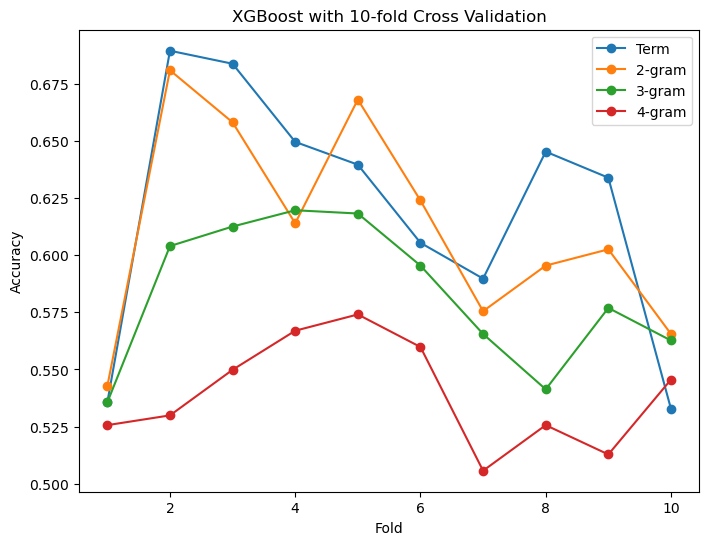


Classification Report (Term):
              precision    recall  f1-score      support
0              0.633315  0.641644  0.637452  3650.000000
1              0.606261  0.597626  0.601913  3370.000000
accuracy       0.620513  0.620513  0.620513     0.620513
macro avg      0.619788  0.619635  0.619683  7020.000000
weighted avg   0.620328  0.620513  0.620391  7020.000000

Classification Report (2-gram):
              precision    recall  f1-score      support
0              0.627151  0.629041  0.628095  3650.000000
1              0.596904  0.594955  0.595928  3370.000000
accuracy       0.612678  0.612678  0.612678     0.612678
macro avg      0.612027  0.611998  0.612011  7020.000000
weighted avg   0.612631  0.612678  0.612653  7020.000000

Classification Report (3-gram):
              precision    recall  f1-score      support
0              0.602841  0.581370  0.591911  3650.000000
1              0.563429  0.585163  0.574090  3370.000000
accuracy       0.583191  0.583191  0.583191     

In [14]:
# Adjust pandas display options
pd.options.display.max_columns = None
pd.options.display.width = None

def evaluate_model(n_gram, X_train, y_train, ax):
    # Define the parameter grid for the grid search
    param_grid = {
        'n_estimators': [10, 100, 1000],
        'max_depth': [3, 10, 50, 100],
    }

    # Define the XGBoost classifier model
    model = xgb.XGBClassifier()

    # Perform the grid search
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=k, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters
    print(f"{n_gram} - Best hyperparameters: ", grid_search.best_params_)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Compute cross-validated scores and predictions
    scores = cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=k)
    print(f'{n_gram} - Average accuracy: %.3f (+- %.3f)' % (np.mean(scores), np.std(scores)))

    ax.plot(range(1, k+1), scores, '-o', label=n_gram)

    y_pred = cross_val_predict(best_model, X_train, y_train, cv=k)
    report = classification_report(y_train, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    return report_df

k = 10
fig, ax = plt.subplots(figsize=(8, 6))

n_grams = ['Term', '2-gram', '3-gram', '4-gram']
X_train_list = [X_train_term, X_train_2gram, X_train_3gram, X_train_4gram]
y_train_list = [y_train_term, y_train_2gram, y_train_3gram, y_train_4gram]

reports = []
for n_gram, X_train, y_train in zip(n_grams, X_train_list, y_train_list):
    report_df = evaluate_model(n_gram, X_train, y_train, ax)
    reports.append(report_df)

ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.set_title(f'XGBoost with {k}-fold Cross Validation')
ax.legend()
plt.show()

# Print classification reports
for n_gram, report_df in zip(n_grams, reports):
    print(f'\nClassification Report ({n_gram}):')
    print(report_df)
